# Mini Project 2 - Part 1 (100 pts)

## Goal of the Assignment
The goal of this assignment is to answer user queries by retrieving relevant information from a referenced book.

To do this,we will break it down into several steps that include: the design of a Python script that loads a PDF document, breaks it down into smaller chunks, generates embeddings for each chunk using OpenAI's API, stores these embeddings in a Pinecone index, and then uses these embeddings to perform a similarity search and retrieve relevant documents based on a query.

### [Reference Paper on Retrieval Augmented Generation](https://arxiv.org/abs/2005.11401)

## Exercise 0:
1. Go through the OpenAI documnentation here for text embeddings [OpenAPI Docs](https://platform.openai.com/docs/guides/embeddings)
1. Go through the Pinecone and Langchain Integration documentation here [Pinecone](https://docs.pinecone.io/docs/openai)

In [1]:
!pip install langchain
!pip install unstructured
!pip install pdf2image
!pip install pdfminer.six
!pip install unstructured_inference
!pip install pikepdf
!pip install pypdf
!pip install pinecone
!pip install openai
!pip install tiktoken
!pip install pymupdf
!pip install langchain_openai
!pip install langchain-community
!pip install langchain-pinecone
!pip install ipywidgets


[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip insta

In [2]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Pinecone
from pinecone import Pinecone, ServerlessSpec
from tqdm.notebook import tqdm
import langchain
import openai
from openai import OpenAI
import string

## Task 1. Load PDF file and extract text (25 pts)

### You are required to load the PDF file and extract the text from it. You can use PyMuPDFLoader to extract text and page numbers from the PDF file. The extracted text and page numbers should be stored in a variables `page_texts` and `page_numbers`.

### Use the provided PDF file 'machine-learning.pdf' to extract the text from it.
### (5 pts)

In [1]:
from langchain_community.document_loaders import PyMuPDFLoader # PyMuPDFLoader默认按照页数切分documents

pdfPath = "./docs/machine-learning.pdf"
loader = PyMuPDFLoader(pdfPath)
documents = loader.load() # doc langChain object，里面有page_content和metadata

# Extract document per page
page_texts = [doc.page_content for doc in documents]  # Extract page_content, doc.page_content 点语法 doc是对象
# Extract page numbers
page_numbers = [doc.metadata["page"] for doc in documents]  # Extract metadata["page"] 字典取值语法 metadata是字典

print("documents[0].page_content:", documents[0].page_content)
print("***********************")
print("documents[0].metadata:", documents[0].metadata)
print("***********************")
print("documents[0]:", documents[0])
print("***********************")
print("page_texts[0]:", page_texts[0])
print("***********************")
print("page_numbers[0]:", page_numbers[0])



documents[0].page_content: A Course in
Machine Learning
Hal Daumé III
***********************
documents[0].metadata: {'producer': 'pdfTeX-1.40.16', 'creator': 'LaTeX with hyperref package', 'creationdate': '2017-01-20T19:49:25-05:00', 'source': './docs/machine-learning.pdf', 'file_path': './docs/machine-learning.pdf', 'total_pages': 227, 'format': 'PDF 1.5', 'title': 'A Course in Machine Learning', 'author': 'Hal Daumé III', 'subject': '', 'keywords': '', 'moddate': '2017-01-20T19:49:25-05:00', 'trapped': '', 'modDate': "D:20170120194925-05'00'", 'creationDate': "D:20170120194925-05'00'", 'page': 0}
***********************
documents[0]: page_content='A Course in
Machine Learning
Hal Daumé III' metadata={'producer': 'pdfTeX-1.40.16', 'creator': 'LaTeX with hyperref package', 'creationdate': '2017-01-20T19:49:25-05:00', 'source': './docs/machine-learning.pdf', 'file_path': './docs/machine-learning.pdf', 'total_pages': 227, 'format': 'PDF 1.5', 'title': 'A Course in Machine Learning', 'au

# Chunking

### Break down the extracted text into smaller text (typical chunk size is around the length of a page) chunks using RecursiveCharacterTextSplitter (20 pts)

1. Initialize chunking parameters (chunk_size=2500, overlap=50) As an intial starting point
2. Create storage lists for chunks and page numbers
3. Loop through each page, extracting text and page numbers
4. Append the previous page’s tail to the current page
5. Apply text chunking with overlap
6. Store chunks and assign correct page numbers
7. Update previous_page_tail to carry over text to the next page

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

#############################
## TODO: Write your code here
#############################
chunk_size, overlap = 2500, 50
#  Initialize the Text Splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)


# Prepare Variable
chunked_texts = []
chunk_page_numbers = []
previous_page_tail = ""  # 处理跨页的重叠， RecursiveCharacterTextSplitter只在处理单页overlap时生效，跨文档/页面之间不会创建重叠

# Process Each Page with Cross-Page Overlap

# Loop through each page, process text, and ensure overlap is preserved across pages.
# enumerate = 一边遍历，一边给编号i，把每页的text和索引i对上
for i, page_text in enumerate(page_texts):
    current_text = previous_page_tail + page_text
    chunks = text_splitter.split_text(current_text) # each page的chunks[]合集
    
    # update previous_page_tail
    if len(chunks) > 0:
        last_chunk = chunks[-1]
        if len(last_chunk) >= overlap:
            previous_page_tail = last_chunk[-overlap:]
        else:
            previous_page_tail = last_chunk

    # store chunks and page numbers
    for chunk in chunks:
        chunked_texts.append(chunk)
        chunk_page_numbers.append(page_numbers[i]) # 使用当前的页码



    # Prepend the previous page’s overlap to the current page:
    # Split text into chunks using RecursiveCharacterTextSplitter:
    # Store Chunked Text and Page Numbers
    # Update the last `overlap` characters for the next page

## Task 2. Prepare the data (20 pts)
1. Convert the list of texts and page numbers into a DataFrame with a column name 'text' and 'page_number' (5 pts)
2. Preprocess the texts by removing punctuation and new lines (5 pts) 通过去除标点符号和换行符对文本进行预处理
3. Generate embeddings for each text using the embeddings function. (5 pts)
4. Create a new column in the dataframe to store the generated embedding (5 pts)


In [7]:

# OpenAI 的构造函数签名是：__init__(self, api_key=..., ...)
import os
from dotenv import load_dotenv

load_dotenv() # # 加载 .env 文件

openai_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=openai_key)

# Function to get the embeddings of the text using OpenAI text-embedding-3-small model
# encoder: text 文本 -> vector 向量
# create(): 创建 embedding 的 API 调用方法
# input = API 支持批量处理，可以传入多个文本, [text] 必须是列表，即使只有一个文本也要放在列表中
# data：API 返回对象的 data 属性列表，包含所有请求的 embedding 结果
# data[0].embedding: data是API 返回对象的 data 属性列表，data[0] 因为只传了一个文本，所以取第一个结果；embedding是从结果对象中获取 embedding 属性
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

# API 返回的结构
# {
#     "data": [
#         {
#             "embedding": [0.123, -0.456, 0.789, ...],  # 1536个数字
#             "index": 0,
#             "object": "embedding"
#         }
#     ],
#     "model": "text-embedding-3-small",
#     "object": "list",
#     "usage": {
#         "prompt_tokens": 5,
#         "total_tokens": 5
#     }
# }

In [8]:
#############################
## TODO: Write your code here
#############################

# Convert the list of texts into a DataFrame
# DataFrame: pandas 库中的二维表格数据结构，类似 Excel 表格
import pandas as pd
df = pd.DataFrame({
    "text": chunked_texts,
    "page_number": chunk_page_numbers
})


# Preprocess the texts by removing punctuation and new lines
import string
df['text'] = df['text'].str.translate(str.maketrans('', '', string.punctuation))
df['text'] = df['text'].str.replace('\n', ' ',regex=False) # regex=False，替换为普通字符串字面量，而非正则表达式

# Generate embeddings for each text using the embeddings function
# 在 pandas 中，当执行 df['column'] = value 时，它会将 整列 的每一个单元格都填充为同一个值。
# pandas的.apply()可以接受一个函数对象作为参数，自动将函数应用到每一行，并将返回的结果精准地存放在对应的位置。


df['embeddings'] = df['text'].apply(get_embedding)

# 查看结果
print(df.head())
print(f"\nDataFrame 形状: {df.shape}")


                                                text  page_number  \
0         A Course in Machine Learning Hal Daumé III            0   
1  A Course in Machine Learning Hal Daumé IIICopy...            1   
2  imlinfo TODO   Second printing January 2017For...            2   
3  2017For my students and teachers Often the sam...            3   
4  Probabilistic Modeling 116 10 Neural Networks ...            4   

                                          embeddings  
0  [0.005656508728861809, 0.02939603105187416, 0....  
1  [0.00669109309092164, 0.026317643001675606, 0....  
2  [-0.019943011924624443, 0.008549213409423828, ...  
3  [-0.0049791159108281136, 0.031497564166784286,...  
4  [-0.004062092397361994, -0.0393034890294075, 0...  

DataFrame 形状: (331, 3)


## Task 3. Create Pinecone index and insert the data (15 pts)
1. Create a Pinecone index on [`Pinecone Console`](https://www.pinecone.io/) with OpenAI text embedding size dimensions and cosine similarity metric (5 pts)
2. Initialize Pinecone client and connect to the Pinecone index
3. Insert the embeddings, text and other appropriate meta data(in a dictionary see below for example) into the Pinecone index (5 pts). Create namespaces according to the chunking, say you are using chunks of 500, 1000 use namespaces ns500,ns-1000 respectively
4. Get the index info and print the number of records in the index (5 pts)


#### Refer [`Pinecone docs`](https://docs.pinecone.io/docs/overview)

## Format for tuple required for Pinecone index
```python
(
    "unique_id_for_each_record",
    document_embedding_vector,
    {
        "text": "document_text",
        "num_tokens": "number_of_tokens_in_document"
        "other_meta_data": "other_meta_data"
    }
)
```

Example upsert into `pinecone_index`
```python
pinecone_index.upsert(
  vectors=[
    {"id": "vec1", "values": [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], "metadata": {"text": [....],"page_number": [1]}},
    {"id": "vec2", "values": [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], "metadata": {"text": [....],"page_number": [1]}},
    {"id": "vec3", "values": [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3], "metadata": {"text": [....],"page_number": [2]}},
    {"id": "vec4", "values": [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], "metadata": {"text": [....],"page_number": [3]}}
  ],
  namespace="ns500"
)

pinecone_index.upsert(
  vectors=[
    {"id": "vec5", "values": [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], "metadata": {"text": [....],"page_number": [5]}},
    {"id": "vec6", "values": [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6], "metadata": {"text": [....],"page_number": [5]}},
    {"id": "vec7", "values": [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7], "metadata": {"text": [....],"page_number": [6]}},
    {"id": "vec8", "values": [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8], "metadata": {"text": [....],"page_number": [7]}}
  ],
  namespace="ns1000"
)
```

In [ ]:
from pinecone import Pinecone, ServerlessSpec
import os, time
from dotenv import load_dotenv

load_dotenv() # # 加载 .env 文件

# ---- 3.2 Initialize Pinecone client and connect to the Pinecone index ---- 
pinecone_key = os.getenv('PINECONE_API_KEY')
pc = Pinecone(api_key=pinecone_key)

INDEX_NAME = "machine-learning-textbook" # TODO: change to your Pinecone index name

# Create index 存储和检索向量数据的容器
existing = [x["name"] for x in pc.list_indexes()]
if INDEX_NAME not in existing:
    pc.create_index(
        name=INDEX_NAME,
        dimension=1536,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    # wait until ready
    while not pc.describe_index(INDEX_NAME).status["ready"]:
        time.sleep(2)

index = pc.Index(INDEX_NAME)
print("Connected to:", INDEX_NAME)


#############################
# TODO: Write your code here (3.3)
#############################
# ---- 3.3 Insert (upsert) embeddings + text + metadata ----
# Insert the embeddings, text and other appropriate meta data
vectors = []

for id, row in df.iterrows():
    vector_data = {
        "id": str(id),
        "values": row['embeddings'],
        "metadata": {
            "text": row['text'],
            "page_number": row['page_number']
        }
    }
    vectors.append(vector_data)

BATCH_SIZE = 100
NAMESPACE = "ns2500"

for i in range(0, len(vectors), BATCH_SIZE):
    batch = vectors[i:i+BATCH_SIZE]
    index.upsert(vectors=batch, namespace=NAMESPACE)


Connected to: machine-learning-textbook


In [10]:
#Get index info and print the number of records 
print("Index stats:", index.describe_index_stats())

Index stats: {'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'ns2500': {'vector_count': 331},
                'ns500': {'vector_count': 1261}},
 'total_vector_count': 1592,
 'vector_type': 'dense'}


In [23]:
# Experiment preparation：Upload different chunk sizes

def process_and_upload(target_chunk_size, target_namespace):
    print(f"\n--- Processing for Chunk Size {target_chunk_size} (Namespace: {target_namespace}) ---")

    # 1. Chunking
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=target_chunk_size,
        chunk_overlap=50, # Keep overlap consistent
        length_function=len,
        is_separator_regex=False
    )

    chunked_texts = []
    chunk_page_numbers = []
    previous_page_tail = ""

    # Reuse page_texts and page_numbers from Task 1
    for i, page_text in enumerate(page_texts):
        current_text = previous_page_tail + page_text
        chunks = text_splitter.split_text(current_text) # each page的chunks[]合集
        
        # update previous_page_tail
        if len(chunks) > 0:
            last_chunk = chunks[-1]
            if len(last_chunk) >= overlap:
                previous_page_tail = last_chunk[-overlap:]
            else:
                previous_page_tail = last_chunk

        # store chunks and page numbers
        for chunk in chunks:
            chunked_texts.append(chunk)
            chunk_page_numbers.append(page_numbers[i]) # 使用当前的页码


    # 2. DataFrame & Cleaning
    
    temp_df = pd.DataFrame({'text': chunked_texts, 'page_number': chunk_page_numbers})
    temp_df['text'] = temp_df['text'].str.translate(str.maketrans('', '', string.punctuation))
    temp_df['text'] = temp_df['text'].str.replace('\n', ' ',regex=False) # Reuse your clean_text function

    print(f"Generated {len(temp_df)} chunks. Generating embeddings...")

    # 3. Embeddings
    # Reuse your get_embedding function
    temp_df['embeddings'] = temp_df['text'].apply(get_embedding)


    # 4. Upsert to Pinecone
    vectors = []
    for i, row in temp_df.iterrows():
        vectors.append({
            "id": str(i),
            "values": row['embeddings'],
            "metadata": {
                "text": row['text'], 
                "page_number": int(row['page_number'])
            }
        })

    # Batch upsert
    batch_size = 100
    for i in range(0, len(vectors), batch_size):
        index.upsert(vectors=vectors[i:i+batch_size], namespace=target_namespace)

    print(f"Successfully uploaded to {target_namespace}!")

process_and_upload(1000, "ns1000")
process_and_upload(500, "ns500")


--- Processing for Chunk Size 1000 (Namespace: ns1000) ---
Generated 662 chunks. Generating embeddings...
Successfully uploaded to ns1000!

--- Processing for Chunk Size 500 (Namespace: ns500) ---
Generated 1261 chunks. Generating embeddings...
Successfully uploaded to ns500!


## Task 4. Query the vector store Implementation (30 pts)
1. Initialize the vectorstore with the Pinecone index and the embeddings (refer Pinecone docs). (5 pts)
2. Create a function to perform a similarity search on the vectorstore with a query and return the most relevant documents top-5 (top-k). (10 pts)
3. Call the query_pinecone_vector_store function and print the text and page numbers for the top 5 queries (5 pts)
3. Experiment with different text chunk sizes(min 3) for querying the Pinecone index and report the best chunk size. Also explain the reason for the best chunk size (10 pts)

In [11]:
#############################
## TODO: Create Pinecone vector store（langChain）
#############################
from langchain_pinecone import PineconeVectorStore

embeddings = OpenAIEmbeddings(model="text-embedding-3-small", api_key=openai_key)

vector_store = PineconeVectorStore.from_existing_index(
    index_name= INDEX_NAME,
    embedding=embeddings,
    namespace="ns2500"
)


In [12]:
#############################
## TODO: Function to query the Pinecone vector store and return the top-k results

def query_pinecone_vector_store(query: str, top_k: int = 5, nameSpace: str = "ns2500"):
    results = vector_store.similarity_search(
        query=query,
        k=top_k,
        namespace=nameSpace
    )
    
    return results


In [24]:
#############################
## TODO: Call query_pinecone_vector_store and print the text and the Page number for your query
query = "What is the definition of supervised learning?"
top_k = 5
nameSpace = "ns2500"

results = query_pinecone_vector_store(query, top_k, nameSpace)

for result in results:
    print(f"Text: {result.page_content}")
    print(f"Page Number: {result.metadata['page_number']}")
    print("-" * 50)
############################

Text: context to choose among them – Karen SpärckJones74 a course in machine learning truefalse questions and only one of them is true it is unlikely you will study very long Really the problem is not with the data but rather with the way that you have deﬁned the learning problem That is to say what you care about is not accuracy you care about something else If you want a learning algorithm to do a reasonable job you have to tell it what you want Most likely what you want is not to optimize accuracy but rather to optimize some other measure like fscore or AUC You want your algorithm to make some positive predictions and simply prefer those to be “good” We will shortly discuss two heuristics for dealing with this problem subsampling and weighting In subsampling you throw out some of your negative examples so that you are left with a bal anced data set 50 positive 50 negative This might scare you a bit since throwing out data seems like a bad idea but at least it makes learning much mor

In [26]:
##############################
## TODO: Experiment with different text chunk sizes(min 3) for querying the Pinecone index and report the best chunk size. 
#############################
queries = ["What is supervised learning?", "Explain the bias-variance tradeoff."]
namespaces = ["ns500", "ns1000", "ns2500"]

for ns in namespaces:
    print(f"\n\n====== Testing Namespace: {ns} ======")
    for q in queries:
        print(f"\nQuery: {q}")
        res = query_pinecone_vector_store(q, top_k=1, nameSpace=ns)
        if res:
            print(f"Top Result (Page {res[0].metadata['page_number']}):")
            print(f"Text: {res[0].page_content[:150]}...")
        else:
            print("No results found.")



====== Testing Namespace: ns500 ======

Query: What is supervised learning?
Top Result (Page 177.0):
Text: 00001 145 Further Reading TODO further reading15  UNSUPERVISED LEARNING Dependencies If you have access to labeled training data you know what to do T...

Query: Explain the bias-variance tradeoff.
Top Result (Page 70.0):
Text: might be data saturated 59 BiasVariance Tradeoff Because one of the key questions in machine learning is the question of representation it is common t...


====== Testing Namespace: ns1000 ======

Query: What is supervised learning?
Top Result (Page 35.0):
Text: What is the difference between un supervised and supervised learning that means that we know what the “right answer” is for supervised learning but no...

Query: Explain the bias-variance tradeoff.
Top Result (Page 70.0):
Text: near 0 error then you need to work on better feature design or pick another learning model eg decision tree versus linear model If not you probably do...


====== Testing N

### Explain the reason for the best chunk size

After comparative testing, **chunk_size=1000 performs best**.

#### Evidence 1: Query "What is supervised learning?"
- ns500 returned content about UNSUPERVISED learning (page 177), which is related but inaccurate
- **ns1000 directly hit** the definition of "supervised learning" (page 35), accurately answering the question
- ns2500 failed to return high-quality results

#### Evidence 2: Query "Explain the bias-variance tradeoff."
- All configurations found relevant content on page 70
- ns500 most precisely located the title, but lacked explanatory context
- **ns1000 returned a complete explanation**, including concepts and application examples
- ns2500 contained too much irrelevant feature engineering content

### Conclusion

**Optimal chunk_size: 1000 characters**

Rationale:
1. **Semantic Completeness**: 1000 characters typically contain 1-2 complete paragraphs, ensuring complete concept expression
2. **Retrieval Accuracy**: Precisely locates topics without losing context due to over-segmentation
3. **Robustness**: Performs consistently across different types of queries
4. **Practicality**: Returned text length is moderate, allowing users to read directly without filtering excessive information

Smaller chunk size (500) is more precise but prone to "out of context" issues.
Larger chunk size (2500) includes more context but also introduces more noise, reducing relevance scores.

1000 characters is the **optimal balance** between precision and completeness.


## Task 5. Retrieval Augmented Generation (10 pts)
Once you have identified the most similar text to your query from the Pinecone database, you will use this text as an input prompt to a language model. Specifically, you will be using the GPT-3.5 model provided by the OpenAI API. The model will generate a query answer based on the input prompt. (10 pts)

The prompt should handle only the queries that are only relevant to the document.
Ex: If my query is "How to cook an egg?" 
The response should be " this query is not relevant to the context of this book. I would be happy to answer the question based on the books context."

In [27]:
#############################
## TODO: Using OpenAI API answer the query
## TODO: with the top-k results as context
#############################

def get_rag_response(query: str, namespace: str = "ns1000"):
    """
    Retrieves context from Pinecone and generates an answer using GPT-3.5.
    If the query is irrelevant, returns a standard refusal message.
    """

    # 1. Retrieve top-k context chunks from Pinecone
    # We use the function defined in Task 4.
    # Using 'ns1000' as it was determined to be the best chunk size.
    retrieved_docs = query_pinecone_vector_store(query, top_k=5, nameSpace=namespace)

    # 2. Construct the Context String
    # Combine the text from the retrieved documents
    context_text = "\n\n".join([doc.page_content for doc in retrieved_docs])

    # 3. Define the Prompt for GPT
    # The system prompt enforces the strict rule about irrelevant queries.
    system_prompt = """You are a helpful teaching assistant for a Machine Learning textbook.

    Instructions:
    1. Answer the user's Question strictly using ONLY the provided Context.
    2. If the answer cannot be found in the Context, or if the Question is not relevant to the domain of Machine Learning or the provided text, you MUST respond with EXACTLY this sentence:
    "this query is not relevant to the context of this book. I would be happy to answer the question based on the books context."
    3. Do not invent information not present in the Context.
    """

    user_prompt = f"Context:\n{context_text}\n\nQuestion:\n{query}"

    # 4. Call OpenAI API (GPT-3.5-turbo)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.0 # Set to 0 to minimize hallucinations
    )

    return response.choices[0].message.content


In [28]:
## TODO: Create 5 test prompts to get a response from GPT. Make sure to include some relevant and some irrelevant

test_queries = [
    "What is supervised learning?",        # Relevant
    "How to cook an egg?",            # Irrelevant (Completely off-topic)
    "Explain the bias-variance tradeoff.",    # Relevant
    "Who won the Super Bowl in 2026?",     # Irrelevant (Fact not in book)
    "What is a decision tree?"          # Relevant
]

print("------ RAG System Test Results ------\n")

# Loop through queries and print responses
for q in test_queries:
    print(f"User Query: {q}")
    ans = get_rag_response(q)
    print(f"AI Response: {ans}")
    print("-" * 50)

------ RAG System Test Results ------

User Query: What is supervised learning?
AI Response: Supervised learning is the setting in which you have access to labeled training data, where a teacher provides the right answers for the data.
--------------------------------------------------
User Query: How to cook an egg?
AI Response: this query is not relevant to the context of this book. I would be happy to answer the question based on the book's context.
--------------------------------------------------
User Query: Explain the bias-variance tradeoff.
AI Response: Here the second term, the approximation error, measures the quality of the chosen classifier compared to the best possible classifier within the set of all possible classifiers using a fixed representation. The bias-variance tradeoff is a key concept in machine learning that involves balancing the estimation error (bias) and the approximation error (variance) when selecting a classifier.
----------------------------------------

# Mini Project 2 - Part 2: Building a Chatbot with OpenAI's GPT-3.5-turbo Model (50 pts)

## Goal

The goal of this assignment is to design a chatbot using OpenAI's GPT-3.5-turbo model and the Streamlit library in Python. The chatbot should be able to maintain a conversation history and generate responses to user inputs.

## Action Items

1. **Import the necessary libraries**: Import the OpenAI and Streamlit libraries, which are necessary for interacting with the OpenAI API and creating the chat interface, respectively.

2. **Initialize the OpenAI client**: Initialize the OpenAI client with your API key using the `OpenAI()` constructor.


3. **Initialize the session state**: Check if the "openai_model" and "messages" keys exist in the session state. If they don't, initialize them with the GPT-3.5-turbo model and an empty list, respectively.

4. **Display the conversation history**: Iterate over all the messages in the session state and create a chat message for each one with the appropriate role and content.

5. **Wait for user input**: Use the `st.chat_input()` function to wait for the user to input a message.

6. **Add the user's message to the conversation**: If a message is inputted, add it to the session state's messages list and display it in the chat interface.

7. **Generate the assistant's response**: Send a request to the OpenAI API to generate a response from the assistant. This request should include all the previous messages in the conversation.

8. **Display the assistant's response**: Add the assistant's response to the session state's messages list and display it in the chat interface.

9. **Define a function to get the conversation history**: Define a function `get_conversation()` that iterates over all the messages in the session state and concatenates them into a single string, each message prefixed by the role of the sender. **(Not required for Part-2, will be useful in Part-3)**

By following these action items, you should be able to create a chat interface where the user can have a conversation with an AI assistant powered by OpenAI's GPT-3.5-turbo model.



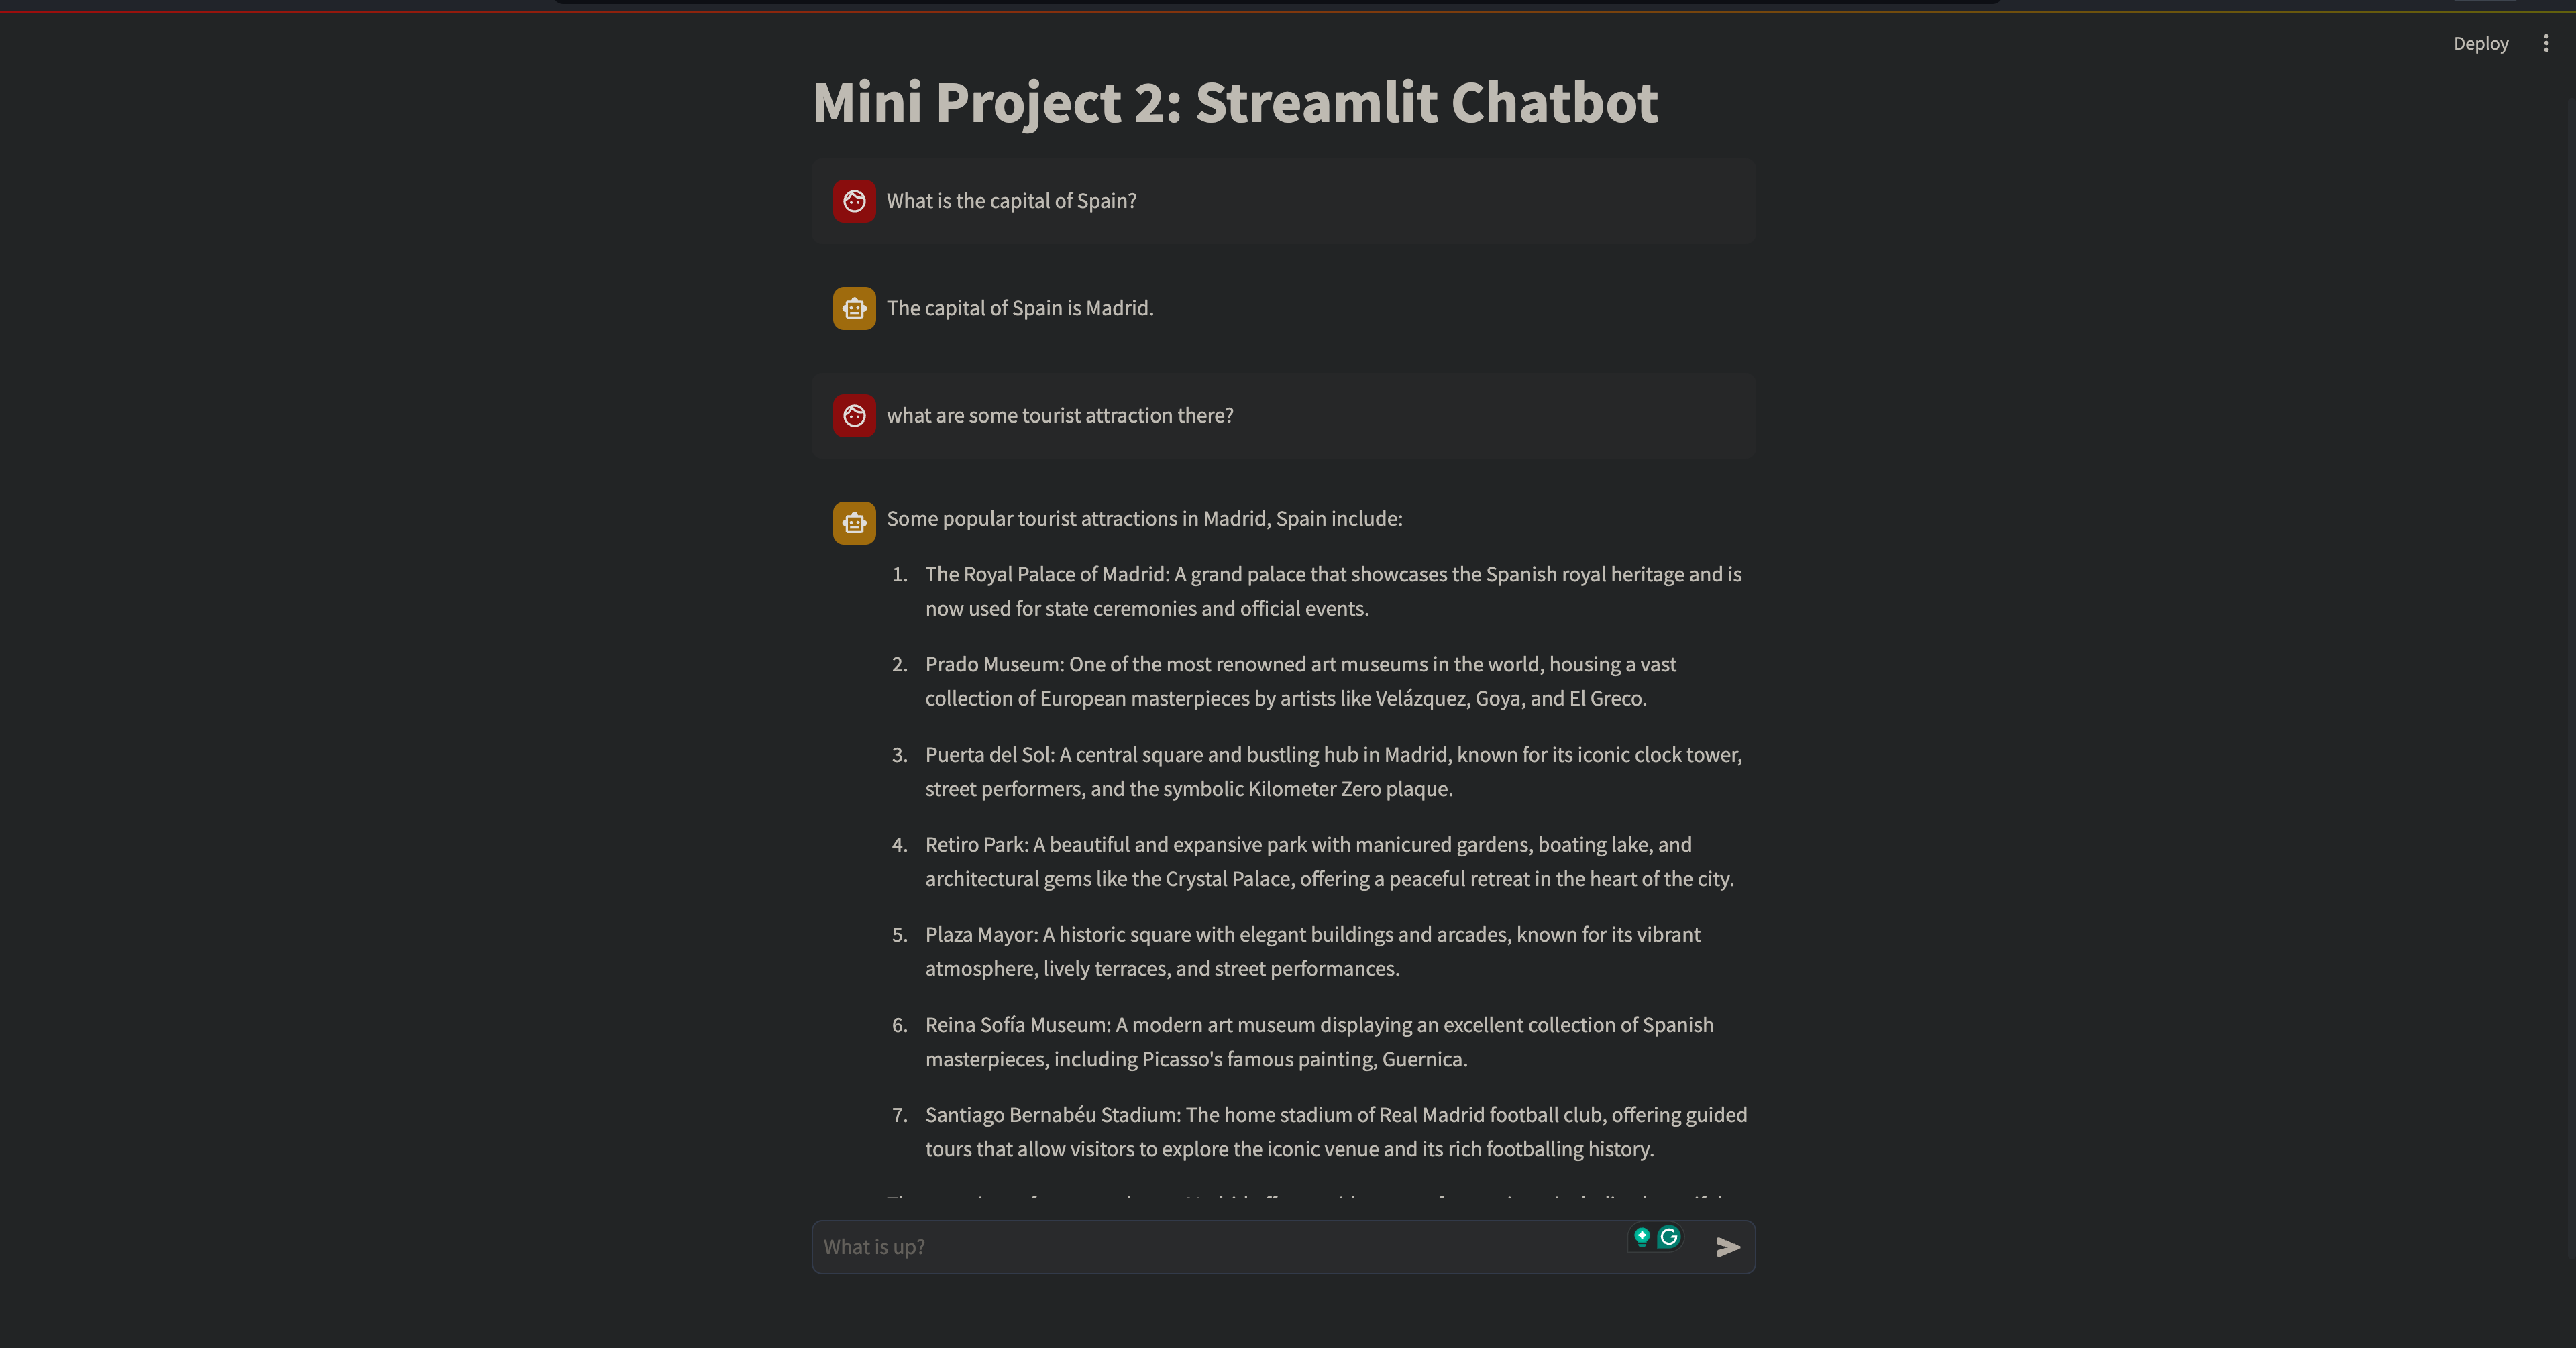The end result should look like this

In [18]:
# Import the necessary libraries
import streamlit as st
from openai import OpenAI  # TODO: Install the OpenAI library using pip install openai

st.title("Mini Project 2: Streamlit Chatbot")

# TODO: Replace with your actual OpenAI API key
# client = OpenAI(api_key='sk-YOUR_API_KEY')

# Define a function to get the conversation history (Not required for Part-2, will be useful in Part-3)
def get_conversation() -> str:
    # return: A formatted string representation of the conversation.
    # ... (code for getting conversation history)

# Check for existing session state variables
if "openai_model" not in st.session_state:
    # ... (initialize model)

if "messages" not in st.session_state:
    # ... (initialize messages)

# Display existing chat messages
# ... (code for displaying messages)

# Wait for user input
if prompt := st.chat_input("What would you like to chat about?"):
    # ... (append user message to messages)

    # ... (display user message)

    # Generate AI response
    with st.chat_message("assistant"):
        # ... (send request to OpenAI API)

        # ... (get AI response and display it)

    # ... (append AI response to messages)


IndentationError: expected an indented block after function definition on line 11 (2896646241.py, line 16)

## Submissions for Part 1 and Part 2

## Part 1
1. solution.ipynb file
2. The .ipynb file should contain the explaination for the reason for the best chunk size (5 pts)
3. The .ipynb file should contain the OpenAI API answer for different queries both relevant and non-relavent to the RAG document (5 pts)

## Part 2
1. app.py file 
2. A report.pdf file containing the screenshots of conversation with the AI Chatbot for diffrent queries (10 pts)

